<a href="https://colab.research.google.com/github/Polinia/skillfactory_rds/blob/main/module_6/recommendation_system_for_amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation system for Amazon items

Goals and objectives: development of a recommendation system for a large online retail company. The recommendation system should be based on the most accurate recommendation of the right product in a high price category.

**Importing Libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
from collections import Counter
import json
import re
import seaborn as sns
from datetime import datetime
from pandas import Series
import matplotlib.pyplot as plt

import pandas_profiling

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif

import os
from sklearn.metrics import auc, roc_auc_score, roc_curve
import warnings 
warnings.simplefilter('ignore')

function for ROC-curve plot:

In [ ]:
def roc_auc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Random classifier', linestyle='--')
    plt.plot(fpr, tpr, label = 'LightFM')
    plt.title('ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

function for feature description:

In [ ]:
def description(feat):
    print(feat.value_counts())
    print(feat.describe())
    print("gaps:", feat.isnull().sum())

In [ ]:
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

Description:

test.csv - the dataset I will do the predictions for. Each set has userid, itemid has its own id for which you have to make a prediction.

* overall - rating given by the user
* verified - if the review was verified
* reviewTime - when the review was written
* reviewerName - reviwer name
* reviewText - review text
* summary - summary
* vote - number of votes per comment
* style - metadata
* image - product image
* userid - user id 
* itemid - product id 
* id - id for prediction

In [ ]:
# read json with metadata and put the result in the "meta" dataset
# there is probably data here that can improve our model
with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))
        
meta = pd.DataFrame(meta_list)

In [ ]:
# quick look
pd.set_option('display.max_columns', None)
print('Dimension of the training dataset: ', train.shape)
display(train.head(5))
print('Dimension of the testing dataset: ', test.shape)
display(test.head(5))
print('Dimension of the meta dataset: ', meta.shape)
display(meta.head(5))

Dimension of the training dataset:  (857895, 14)


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


Dimension of the testing dataset:  (285965, 11)


,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


Dimension of the meta dataset:  (287209, 17)


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN


The primary analysis of the three datasets shows that these are quite large datasets. The features from the training and meta datasets do not fully match the test ones. There are three more columns in the training dataset:

* overall - score on a five-point scale
* reviewText - text review 
* summary - review summary 
* rating - target variable

missing Id - id for prediction

At the same time, it is possible to combine datasets, it can be done on 'asin', which is a unique product identifier on Amazon.

In [ ]:
# drop duplicates
train.drop_duplicates(inplace = True)

In [ ]:
# form a new dataset after combining metadata and training dataset
train_new = pd.merge(train, meta, on='asin')

**EDA**

In [ ]:
# let's start working with a new dataset
train_new.head(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5.0,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,NaN,117314,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
2,3.0,True,"03 11, 2017",B01CPNIEQG,Ella,"Ummm....interesting spice blend, but not reall...","It's not a bad taste, but they really shouldn'...",1489190400,4.0,NaN,NaN,119505,37138,0.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


In [ ]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         847593 non-null  float64
 1   verified        847593 non-null  bool   
 2   reviewTime      847593 non-null  object 
 3   asin            847593 non-null  object 
 4   reviewerName    847425 non-null  object 
 5   reviewText      847315 non-null  object 
 6   summary         847426 non-null  object 
 7   unixReviewTime  847593 non-null  int64  
 8   vote            118861 non-null  object 
 9   style           440351 non-null  object 
 10  image_x         7138 non-null    object 
 11  userid          847593 non-null  int64  
 12  itemid          847593 non-null  int64  
 13  rating          847593 non-null  float64
 14  category        847593 non-null  object 
 15  description     776098 non-null  object 
 16  title           847593 non-null  object 
 17  brand     

In [ ]:
print("missing values in train:", train_new.isnull().sum())
print("missing values in test:", test.isnull().sum())

missing values in train: overall                0
verified               0
reviewTime             0
asin                   0
reviewerName         168
reviewText           278
summary              167
unixReviewTime         0
vote              728732
style             407242
image_x           840455
userid                 0
itemid                 0
rating                 0
category               0
description        71495
title                  0
brand               6104
rank               34598
also_view         384222
main_cat             955
price             258621
also_buy          120735
image_y            92239
date              835506
feature           704859
details            14608
similar_item      846455
tech1             843221
fit               847593
dtype: int64
missing values in test: verified               0
reviewTime             0
asin                   0
reviewerName          47
unixReviewTime         0
vote              246503
style             138285
image        

We see that there are 30 features of different types in the training dataset. Some features have a large number of gaps. There are also features with a large number of gaps in the test dataset. Let's start a step-by-step analysis of features.

In [ ]:
# use the module for quick primary data analysis, if there is time
# pandas_profiling.ProfileReport(test)

In [ ]:
#We will add features to a specific list:
#numeric:
num_cols = []

# binary
bin_cols = []

# categorical
cat_cols = []

In [ ]:
df = train_new.copy()

* overall

In [ ]:
description(df.overall)

5.0    607524
4.0    111868
3.0     59795
1.0     37071
2.0     31335
Name: overall, dtype: int64
count    847593.000000
mean          4.441068
std           1.065026
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64
gaps: 0


<AxesSubplot:>

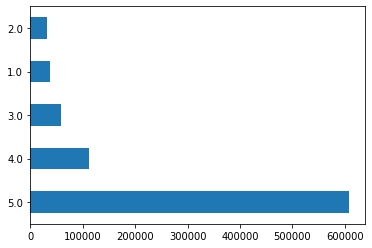

In [ ]:
df.overall.value_counts().plot.barh()


Feature 'overall' is a 5-point scale for product ratings by users. There are no missing values. It is absent in the test dataset. It can be included in categorical features.

In [ ]:
df['overall']=df['overall'].astype('int32')

In [ ]:
cat_cols.append('overall')

In [ ]:
df.head(2)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN
1,5,False,"03 31, 2017",B01CPNIEQG,Tina McClain,Love this seasoning on chicken! The flavor is ...,Love all their seasoning!!,1490918400,NaN,NaN,NaN,117314,37138,1.0,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...",[Adobo seasoning (known as adobo seco) is a ve...,"Primal Palate Organic Spices Adobo Seasoning, ...",Primal Palate Organic Spices,"19,771inGroceryGourmetFood(","[B00AJRKRJS, B01NALHAY9, B01DGZ2B48, B01EZ489A...",Grocery,$9.95,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


* verified

In [ ]:
description(df.verified)

True     736369
False    111224
Name: verified, dtype: int64
count     847593
unique         2
top         True
freq      736369
Name: verified, dtype: object
gaps: 0


<AxesSubplot:xlabel='verified', ylabel='count'>

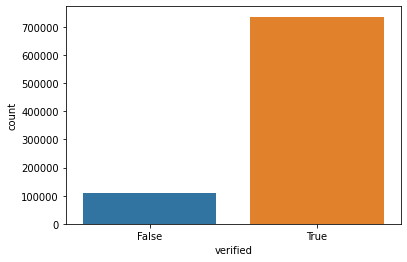

In [ ]:
sns.countplot(x = 'verified', data = df)

In [ ]:
# Converting the values in the 'verified' column
df['verified'] = df['verified'].map(lambda x: 1 if x == True else 0).astype('int')

The indicator means verification of the user's feedback. Available in the test dataset. Let's add it to the list of binary features.

In [ ]:
bin_cols.append('verified')

* reviewTime

The description says that this is the time when the review was written, we also have a feature of the same, but in the Unix format unixReviewTime. Obviously, 'reviewTime' should be removed, since this is a hundred percent correlation.

In [ ]:
df = df.drop(['reviewTime'], axis=1)

* asin

In [ ]:
description(df.asin)

B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B0001LO3FG    4252
B00R7PWK7W    2449
              ... 
B000SARZ64       1
B006LQVN7G       1
B0045GWZ3K       1
B007WPLDCK       1
B019YHTJ56       1
Name: asin, Length: 41302, dtype: int64
count         847593
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object
gaps: 0


In [ ]:
# look at the most popular purchase - this is a $13.7 bar from KIND
pd.set_option('display.max_columns', None)
display(df[df.asin == 'B00BUKL666'][:2])

,overall,verified,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image_x,userid,itemid,rating,category,description,title,brand,rank,also_view,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
9103,5,1,B00BUKL666,E.S.,The dark chocolate and sea salt are a deliciou...,Great taste!,1488585600,NaN,NaN,NaN,111921,22208,1.0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nu...",[These bars are where our journey started and ...,"KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...",KIND,18inGroceryGourmetFood(,NaN,Grocery,$13.67,"[B003TNANSO, B003TMZQC8, B00IZF0LCE, B003TN6FS...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN
9104,5,1,B00BUKL666,booksrock,Delicious! My second favorite Kind bar!,My second favorite Kind bar,1504137600,NaN,NaN,NaN,123191,22208,1.0,"[Grocery & Gourmet Food, Snack Foods, Bars, Nu...",[These bars are where our journey started and ...,"KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...",KIND,18inGroceryGourmetFood(,NaN,Grocery,$13.67,"[B003TNANSO, B003TMZQC8, B00IZF0LCE, B003TN6FS...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: ...",NaN,NaN,NaN


There are 41302 unique products in our database. It is not clear how it can be useful. Probably worth removing it.

In [ ]:
#remove
df = df.drop(['asin'], axis=1)

* reviewerName

In [ ]:
description(df.reviewerName)

Amazon Customer         31346
Kindle Customer          6128
Linda                     729
John                      714
David                     606
                        ...  
Ra&#039;ad Al Homoud        1
Shalene                     1
Emily G                     1
Temptd2                     1
rivkaf                      1
Name: reviewerName, Length: 101207, dtype: int64
count              847425
unique             101207
top       Amazon Customer
freq                31346
Name: reviewerName, dtype: object
gaps: 168


<AxesSubplot:>

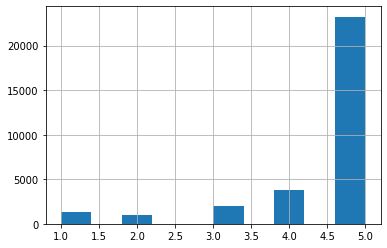

In [ ]:
# dependence of ratings on the nickname Amazonian buyer
df['overall'][df['reviewerName'] == 'Amazon Customer'].hist(bins=10)

It is obvious that non-unique names are specified in this feature. If you look at the dependence of estimates on the most common names, the distributions are almost identical. It is difficult to understand how this feature can be useful in the model. Although, you can come up with a recommendation system 'buyers with the same name as yours most often buy ...'. But this does not correspond to our current task. Let's remove the feature.

In [ ]:
df = df.drop(['reviewerName'], axis=1)

* reviewText

This attribute is a more extended version of the summary attribute; it is not in the test dataset. We can delete it.

In [ ]:
df = df.drop(['reviewText'], axis=1)

* summary

In [ ]:
description(df.summary)

Five Stars                                      171328
Four Stars                                       26597
Three Stars                                      11913
One Star                                          5300
Two Stars                                         4920
                                                 ...  
Good standby food                                    1
Can it BE! Canned Chili that taste GOOD!             1
Campbell's chilli tastes very good over rice         1
Very good for canned chilli                          1
Wonderfully mild flavor                              1
Name: summary, Length: 411451, dtype: int64
count         847426
unique        411451
top       Five Stars
freq          171328
Name: summary, dtype: object
gaps: 167


This feature is also absent in the test sample. But here you can work in the future - create a list of the most popular words. For example word_list = ['Five Stars', 'Four Stars'] etc. Then break them down by criteria and make dummy variables. Keep this thought in mind in case we need to work with additional features. Until then, we'll remove it.

In [ ]:
df = df.drop(['summary'], axis=1)

* unixReviewTime

In [ ]:
tsmin = datetime.utcfromtimestamp(df.unixReviewTime.min()).strftime('%Y-%m-%d %H:%M:%S')
tsmax = datetime.utcfromtimestamp(df.unixReviewTime.max()).strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
print(tsmin)
print(tsmax)
# all reviews are from 2000 to 2018

2000-08-09 00:00:00
2018-10-02 00:00:00


In [ ]:
tsmin = df.unixReviewTime.min()
ts25 = int(df.unixReviewTime.quantile(0.25))
ts50 = int(df.unixReviewTime.quantile(0.50))
ts75 = int(df.unixReviewTime.quantile(0.75))
tsmax = df.unixReviewTime.max()

In [ ]:
def cat_date(x):
    if x <= ts25: x = 'old'
    elif ts25 < x < ts75: x = 'middle'
    elif ts75 <= x: x = 'new'
    return x      

# Replace the values in the column with categories
df['unixReviewTime'] = df['unixReviewTime'].apply(lambda x: cat_date(x))

* vote

In [ ]:
description(df.vote)

2.0      30774
3.0      15336
2        13786
4.0       8893
3         6969
         ...  
1,491        1
195          1
594.0        1
278          1
153          1
Name: vote, Length: 477, dtype: int64
count     118861.0
unique       477.0
top            2.0
freq       30774.0
Name: vote, dtype: float64
gaps: 728732


In [ ]:
# Remove commas
df['vote'] = df['vote'].astype('str')
df['vote'] = df['vote'].apply(lambda x: x.replace(',', ''))
# filling gaps with 0
df['vote'] = df['vote'].apply(lambda x: x.replace('nan', '0'))
df.vote = df.vote.fillna(0)
# change to int32
df['vote'] = df['vote'].astype('float')
df['vote'] = df['vote'].astype('int32')

<AxesSubplot:>

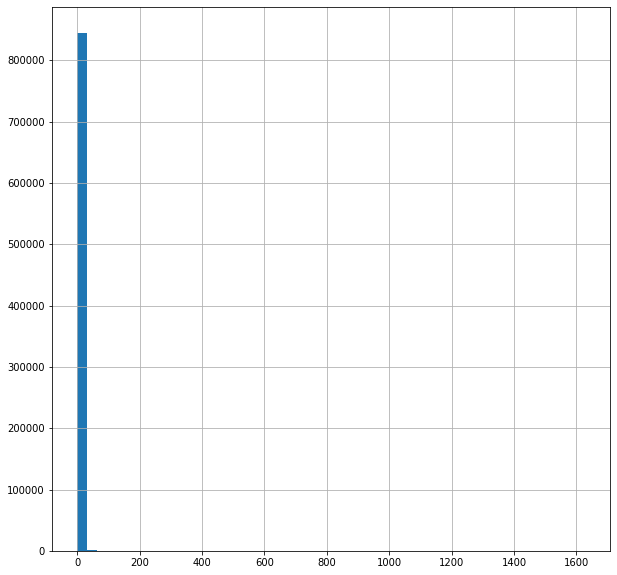

In [ ]:
df['vote'].hist(figsize=(10,10), bins=50)
# obviously most reviews don't have ratings

In [ ]:
print(df.vote.value_counts())

0       728732
2        44560
3        22305
4        12872
5         8275
         ...  
208          1
594          1
269          1
1491         1
153          1
Name: vote, Length: 312, dtype: int64


In [ ]:
# make categories by the number of votes for the review
df["vote"] = df["vote"].apply(lambda x: 'low' if x == 0 else
    'high' if x > 50 else 'middle')

In [ ]:
df['vote'].value_counts()
# in the next section we will transform this data into categorical

low       728732
middle    117360
high        1501
Name: vote, dtype: int64

* style

Despite the fact that this feature is present in the test dataset, there are also a lot of gaps. The signs are difficult to process. Let's delete them

In [ ]:
df = df.drop(['style'], axis=1)

* image_x

In [ ]:
#this sign consists almost entirely of gaps. Let's drop it
df = df.drop(['image_x'], axis=1)

* userid

In [ ]:
description(df.userid)

842       427
17987     317
355       302
2024      296
2809      279
         ... 
24392       1
85135       1
121222      1
6604        1
36635       1
Name: userid, Length: 127448, dtype: int64
count    847593.000000
mean      53756.091163
std       37211.809152
min           0.000000
25%       20347.000000
50%       48581.000000
75%       84723.000000
max      127495.000000
Name: userid, dtype: float64
gaps: 0


user id, feature without gaps. Numerical.

In [ ]:
num_cols.append('userid')

* itemid

In [ ]:
description(df.itemid)

22208    5430
23540    4733
24556    4611
379      4252
32046    2449
         ... 
4557        1
17532       1
12634       1
18946       1
36432       1
Name: itemid, Length: 41302, dtype: int64
count    847593.00000
mean      17090.10489
std       11584.74670
min           0.00000
25%        6478.00000
50%       16108.00000
75%       26719.00000
max       41319.00000
Name: itemid, dtype: float64
gaps: 0



we should remember about checking the missing id in the test and training datasets. This may be needed in the future with item_features.

In [ ]:
num_cols.append('itemid')

* rating

In [ ]:
description(df.rating)

1.0    719392
0.0    128201
Name: rating, dtype: int64
count    847593.000000
mean          0.848747
std           0.358296
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64
gaps: 0


In [ ]:
# a binary feature that probably determines whether a product is good or not
df['rating']=df['rating'].astype('int32')

In [ ]:
bin_cols.append('rating')

* category

In [ ]:
description(df.category)

[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Coffee, Single-Serve Capsules & Pods]     54966
[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Green]                               20301
[Grocery & Gourmet Food, Snack Foods, Bars, Nut Bars]                                              15472
[Grocery & Gourmet Food, Candy & Chocolate, Candy & Chocolate Bars]                                15198
[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Coffee, Roasted Coffee Beans]             14367
                                                                                                   ...  
[Grocery & Gourmet Food, Sauces, Gravies & Marinades, Sauces, Spanish & Mexican, Sofrito Sauce]        3
[Grocery & Gourmet Food, Produce, Fresh Vegetables, Peppers]                                           3
[Grocery & Gourmet Food, Fresh Flowers & Live Indoor Plants, Fresh Cut Flowers, Tulips]                2
[Grocery & Gourmet Food, Produce, Fresh Vegetables, Tom

In [ ]:
# drop
df = df.drop(['category'], axis=1)

* description

In [ ]:
# delete product description
df = df.drop(['description'], axis=1)

* title

In [ ]:
description(df.title)

KIND Bars, Dark Chocolate Nuts & Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count                                                                                                                     7435
KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count                                                                                                                        4733
Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz                                                                                                                                  4611
Twinings of London Pure Camomile Herbal Tea Bags, 20 Count                                                                                                                                           4252
KIND Bars, Caramel Almond and Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count                                                                                                                   

* brand

In [ ]:
description(df.brand)

KIND                22506
Bob's Red Mill      13061
Twinings            11182
Planters            10384
Frontier             6926
                    ...  
EASTSHORE               1
Caffe Vita              1
Mayers                  1
Fuel in a Bottle        1
Genesis Today           1
Name: brand, Length: 8866, dtype: int64
count     841489
unique      8866
top         KIND
freq       22506
Name: brand, dtype: object
gaps: 6104


In [ ]:
# Note that we have a large number of the brand "KIND", we will try to make a new sign out of it
df['brand_kind'] = df.brand.apply(lambda x: 1 if x=='KIND' else 0)

In [ ]:
df['brand_kind'].value_counts()
bin_cols.append('brand_kind')


Unique brands 8866, there are a number of blanks that are easy to fill. I do not think it will be correct to make categorical out of this feature. Let's delete.

In [ ]:
df = df.drop(['brand'], axis = 1)

* rank

In [ ]:
df['rank'][1470]

'2,330inGroceryGourmetFood('

In [ ]:
# dropping
df = df.drop(['rank'], axis = 1)

* main_cat	

In [ ]:
print(df.main_cat.value_counts())
print("gaps:", df.main_cat.isnull().sum())

Grocery                      802613
Health & Personal Care        31705
Amazon Home                    7383
All Beauty                     1522
Sports & Outdoors              1322
Industrial & Scientific         902
Office Products                 631
Toys & Games                    304
Pet Supplies                    125
Tools & Home Improvement         53
Baby                             34
Arts, Crafts & Sewing            19
Home Audio & Theater              9
Camera & Photo                    8
Software                          3
Musical Instruments               3
Cell Phones & Accessories         2
Name: main_cat, dtype: int64
gaps: 955


The category is indicated in which the product is defined. In our database, the undisputed leader is the Grocery category. There are gaps for which you can create the category 'others'. Next, we will make dummy variables or just label encoding out of this feature, and for the future we can also rename some of the less common categories to 'others'.

In [ ]:
df.main_cat = df.main_cat.fillna('others')

* price

In [ ]:
description(df.price)

$14.99              14241
$13.67              10660
$19.99               9043
$14.79               5632
$15.53               5561
                    ...  
$4.62                   2
$35.16                  1
$44.14                  1
$19.99 - $295.00        1
$6.93                   1
Name: price, Length: 4601, dtype: int64
count     588972
unique      4601
top       $14.99
freq       14241
Name: price, dtype: object
gaps: 258621


In [ ]:
df['price'].sample(10)

194589       NaN
233564    $14.99
16608        NaN
676105       NaN
216644    $49.91
99011      $9.66
528274    $24.95
466223    $22.50
50151     $15.53
62994     $14.79
Name: price, dtype: object

You can work with this feature. Remove gaps, prepare for categorization.

In [ ]:
df['price'] = df['price'].astype('str')

In [ ]:
df['price'] = df['price'].apply(lambda x: re.sub('\D', '', x))

In [ ]:
df['price'] = df['price'].apply(lambda x: 0 if x == '' else x)

In [ ]:
df['price'] = df['price'].astype('float')

In [ ]:
df['price'] = df['price'].apply(lambda x: x/100)

In [ ]:
# it is worth defining outliers, otherwise there is a risk of incorrect definition and replacement of gaps with an average
# using a function from earlier projects
def IQR(column):
    perc_25 = df[column].quantile(0.25, interpolation="midpoint")
    perc_75 = df[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    min_out = perc_25 - 1.5 * IQR
    max_out = perc_75 + 1.5 * IQR
    print('Total outliers: {} '.format(
        df[df[column] > max_out][column].count()+df[df[column] < min_out][column].count()))
    print('Upper outliers border:',max_out)

In [ ]:
IQR('price')
# there are a lot of outliers. By expert way we will cut off everything more expensive than $ 100

Total outliers: 18599 
Upper outliers border: 53.75


In [ ]:
df['price'] = df['price'].apply(lambda x: 0 if x > 100 else x)

In [ ]:
# Replace zeros with the mean
df['price'] = df['price'].astype('int')
a = df['price'].mean()
df['price'] = df['price'].apply(lambda x: a if x == 0 else x)

In [ ]:
description(df.price)

13.455983    264415
14.000000     41302
13.000000     33267
9.000000      26349
11.000000     23830
              ...  
88.000000        20
90.000000        19
81.000000        16
97.000000        12
91.000000         7
Name: price, Length: 100, dtype: int64
count    847593.000000
mean         17.653710
std          10.842770
min           1.000000
25%          13.000000
50%          13.455983
75%          20.000000
max          99.000000
Name: price, dtype: float64
gaps: 0


In [ ]:
# make categories by price
df["price"] = df["price"].apply(lambda x: 'low' if x < 10 else
    'high' if x > 20 else 'middle')

* also_buy and also_view

In [ ]:
df.also_buy[78]
# it is obvious that these are also purchased goods by asin, we will remove it at this stage

['B000T9WLUY',
 'B01K23RF7U',
 'B0015GSBUY',
 'B00112KVNW',
 'B004QE5BBE',
 'B01BHJVTJS',
 'B0744J1PTV',
 'B004BQ4V4A',
 'B004QE181G',
 'B01AZ15AMQ',
 'B07CX3FHMB',
 'B0014D0SDG',
 'B00FZGZKHW']

In [ ]:
df.also_view[78]

['B006K3UC86', 'B000WGB3OY']

In [ ]:
print("gaps:", df.also_buy.isnull().sum())
print("gaps:", df.also_view.isnull().sum())

gaps: 120735
gaps: 384222


This feature probably indicates that buyers of a particular product were still browsing. Outliers may indicate that the buyer did not watch anything else.

In [ ]:
# create a pair of features such as the number of products and the number of views
df['also_buy_numb'] = df['also_buy'].str.len()
df['also_view_numb'] = df['also_view'].str.len()
df['also_buy_numb'] = df['also_buy_numb'].fillna(0)
df['also_view_numb'] = df['also_view_numb'].fillna(0)
df['also_buy_numb'] = df['also_buy_numb'].astype(int)
df['also_view_numb'] = df['also_view_numb'].astype(int)

In [ ]:
num_cols.append('also_buy_numb')
num_cols.append('also_view_numb')

In [ ]:
df = df.drop(['also_buy'], axis = 1)
df = df.drop(['also_view'], axis = 1)

The analysis of the data above allows us to decide to remove the remaining features. The main reason is the huge number of gaps

In [ ]:
df.head(2)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,image_y,date,feature,details,similar_item,tech1,fit,brand_kind,also_buy_numb,also_view_numb
0,5,1,middle,low,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,0,85,54
1,5,0,new,low,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN,0,85,54


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847593 entries, 0 to 847592
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         847593 non-null  int32 
 1   verified        847593 non-null  int64 
 2   unixReviewTime  847593 non-null  object
 3   vote            847593 non-null  object
 4   userid          847593 non-null  int64 
 5   itemid          847593 non-null  int64 
 6   rating          847593 non-null  int32 
 7   title           847593 non-null  object
 8   main_cat        847593 non-null  object
 9   price           847593 non-null  object
 10  image_y         755354 non-null  object
 11  date            12087 non-null   object
 12  feature         142734 non-null  object
 13  details         832985 non-null  object
 14  similar_item    1138 non-null    object
 15  tech1           4372 non-null    object
 16  fit             0 non-null       object
 17  brand_kind      847593 non-nu

* image_y

In [ ]:
df.image_y.isna().sum()

92239

Usually, the presence of a product photo inspires more confidence in the consumer when buying by the Internet. Therefore, we will create a binary sign for the presence of a seller’s photo, and then delete the 'image_y' 

In [ ]:
df['image_y'] = df['image_y'].fillna(0)

In [ ]:
df['image']= df['image_y'].apply(lambda x: 0 if x==0 else 1)
df['image']

0         1
1         1
2         1
3         1
4         1
         ..
847588    1
847589    1
847590    1
847591    0
847592    0
Name: image, Length: 847593, dtype: int64

In [ ]:
bin_cols.append('image')

In [ ]:
df = df.drop(['image_y', 'date', 'feature', 'details', 'similar_item', 'tech1', 'fit'], axis=1)

In [ ]:
df.head(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
0,5,1,middle,low,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,0,85,54,1
1,5,0,new,low,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,0,85,54,1
2,3,1,new,middle,119505,37138,0,"Primal Palate Organic Spices Adobo Seasoning, ...",Grocery,low,0,85,54,1


Summary of EDA:

It turned out to be a fairly large base, with which you can creatively work a long time. Most of the variables we removed for various reasons. There are 9 features left. 4 of which are binary, 2 are numeric and the rest are categorical. We will work with some of them using label encoding.

# Future Engeneering

In [ ]:
# transforming with LabelEncoder()
label_encoder = LabelEncoder()
#convert time categories to numeric
mapped = pd.Series(label_encoder.fit_transform(df['unixReviewTime']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'middle', 1: 'new', 2: 'old'}


In [ ]:
df['unixReviewTime'] = label_encoder.fit_transform(df['unixReviewTime'])
df.sample(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
12642,5,0,1,low,123161,22208,1,"KIND Bars, Dark Chocolate Nuts & Sea Salt, Glu...",Grocery,middle,1,95,0,1
536892,4,1,1,middle,9311,6891,1,"Roland Israeli Couscous, Traditional, 21.16 Ou...",Grocery,high,0,66,46,1
281657,5,1,2,low,25367,920,1,"Lipton Black Tea Bags, 100% Natural Tea, 100 ct",Grocery,middle,0,21,47,1


In [ ]:
cat_cols.append('unixReviewTime')

In [ ]:
# transform vote
mapped = pd.Series(label_encoder.fit_transform(df['vote']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'high', 1: 'low', 2: 'middle'}


In [ ]:
df['vote'] = label_encoder.fit_transform(df['vote'])
df.sample(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
609253,4,1,0,2,108471,28701,1,Sincerely Nuts Whole Blue Poppy Seeds 2lb Bag ...,Grocery,middle,0,67,49,1
208170,5,1,0,1,80435,34420,1,"Pop-Tarts, Red Velvet, 14.1 Ounce",Grocery,middle,0,1,0,1
353360,4,1,0,1,3151,3526,1,BUMBLE BEE Sensations Sun-Dried Tomato and Bas...,Grocery,middle,0,76,49,1


In [ ]:
cat_cols.append('vote')

In [ ]:
# transform main_cat
mapped = pd.Series(label_encoder.fit_transform(df['main_cat']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'All Beauty', 1: 'Amazon Home', 2: 'Arts, Crafts & Sewing', 3: 'Baby', 4: 'Camera & Photo', 5: 'Cell Phones & Accessories', 6: 'Grocery', 7: 'Health & Personal Care', 8: 'Home Audio & Theater', 9: 'Industrial & Scientific', 10: 'Musical Instruments', 11: 'Office Products', 12: 'Pet Supplies', 13: 'Software', 14: 'Sports & Outdoors', 15: 'Tools & Home Improvement', 16: 'Toys & Games', 17: 'others'}


In [ ]:
df['main_cat'] = label_encoder.fit_transform(df['main_cat'])
df.sample(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
733643,4,1,1,1,34830,33537,1,"Celestial Seasonings Herbal Tea, Wild Berry Zi...",6,middle,0,34,50,1
217860,5,1,0,1,43516,1535,1,Bob's Red Mill Organic Gluten Free Creamy Buck...,6,high,0,97,59,1
553815,5,1,1,1,46794,37402,1,"Pure Leaf Tea House Collection, Organic Iced T...",6,middle,0,85,0,1


In [ ]:
cat_cols.append('main_cat')

In [ ]:
# let's make dummy variables based on 'price'
dummies = pd.get_dummies(df['price'], prefix = df['price'].name)

In [ ]:
df.head(2)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,price,brand_kind,also_buy_numb,also_view_numb,image
0,5,1,0,1,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,low,0,85,54,1
1,5,0,1,1,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,low,0,85,54,1


In [ ]:
df = df.drop(df['price'].name, axis=1).join(dummies)

In [ ]:
bin_cols.append('price_high')
bin_cols.append('price_middle')
bin_cols.append('price_low')

In [ ]:
bin_cols

['verified',
 'rating',
 'brand_kind',
 'image',
 'price_high',
 'price_middle',
 'price_low']

In [ ]:
df.head(3)

,overall,verified,unixReviewTime,vote,userid,itemid,rating,title,main_cat,brand_kind,also_buy_numb,also_view_numb,image,price_high,price_low,price_middle
0,5,1,0,1,102179,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,0,85,54,1,0,1,0
1,5,0,1,1,117314,37138,1,"Primal Palate Organic Spices Adobo Seasoning, ...",6,0,85,54,1,0,1,0
2,3,1,1,2,119505,37138,0,"Primal Palate Organic Spices Adobo Seasoning, ...",6,0,85,54,1,0,1,0


<AxesSubplot:>

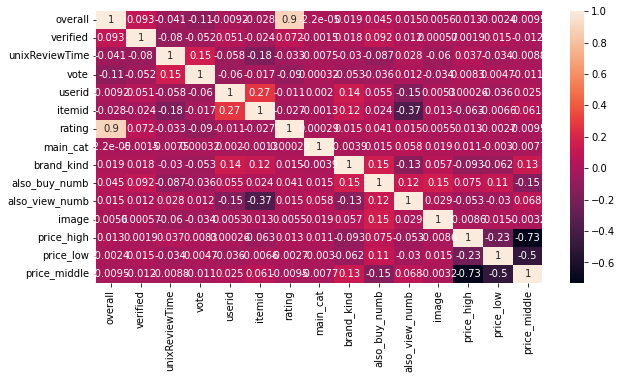

In [ ]:
# correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True)
# it is logical to use this matrix for numerical features, but it is also obvious
# correlation between overall and rating, which corresponds to the task
# consider removing one of the features

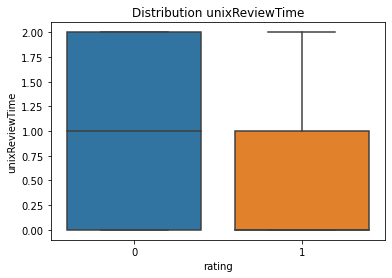

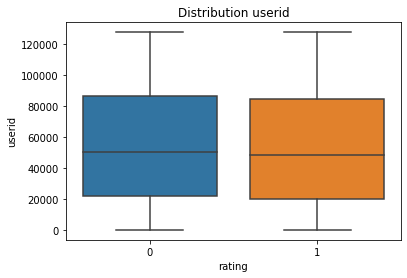

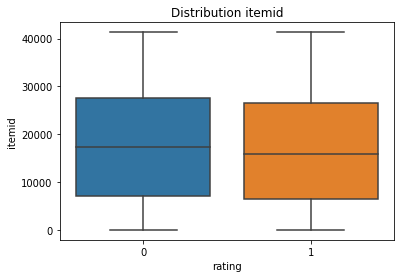

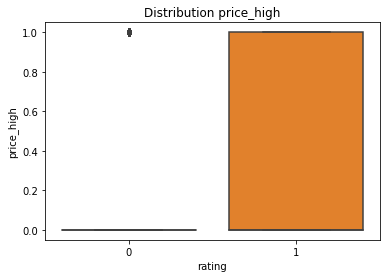

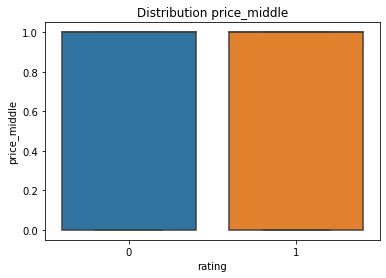

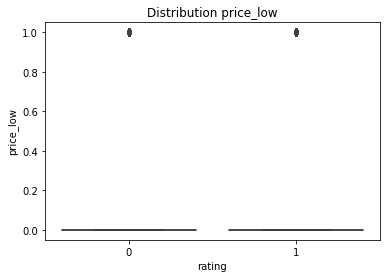

In [ ]:
# to get more information, it is worth building a boxplot of dependencies on the overall or rating
for col in ['unixReviewTime', 'userid', 'itemid', 'price_high', 'price_middle', 'price_low']:
    plt.title(f"Distribution {col}")
    sns.boxplot(x='rating', y=col, data=df)
    plt.show()

The distributions are quite expected. An interesting fact is that products with a high price have a positive rating.

<AxesSubplot:>

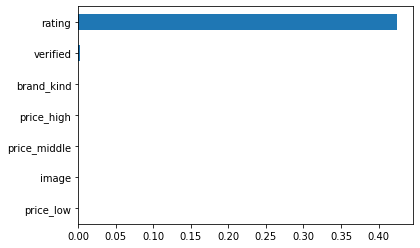

In [ ]:
# Check the significance of binary variables:
imp_bin = Series(mutual_info_classif(df[bin_cols], df['rating'],
                                     discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

Obviously, the price_low feature is of very little importance. Worth considering removal

<AxesSubplot:>

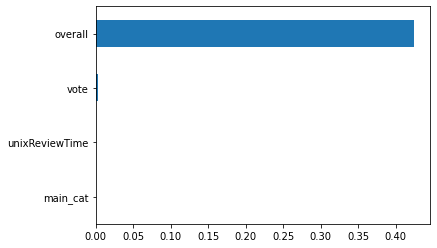

In [ ]:
# Check the significance of categorical variables:
imp_cat = Series(mutual_info_classif(df[cat_cols], df['rating'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

On this plot, 'main_cat' feature is not significant. We have to admit that the graphical representation of our data is not very informative. Let's consider other methods.

In [ ]:
# Apply Student method
from itertools import combinations
from scipy.stats import ttest_ind

In [ ]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'rating'], 
                        df.loc[df.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): 
            print('Statistically significant differences were found for the column', column)
            break

In [ ]:
for col in bin_cols:
    get_stat_dif(col)

Statistically significant differences were found for the column verified
Statistically significant differences were found for the column rating
Statistically significant differences were found for the column brand_kind
Statistically significant differences were found for the column image
Statistically significant differences were found for the column price_high
Statistically significant differences were found for the column price_middle
Statistically significant differences were found for the column price_low


It looks like all features can be helpful.

In [ ]:
# drop 'overall' due to its high correlation
df = df.drop(['overall'], axis = 1)

# Building model

* Simple model

In [ ]:
import scipy.sparse as sparse
from sklearn import preprocessing
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

In [ ]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [ ]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [ ]:
NUM_THREADS = 4 #number of threads
NUM_COMPONENTS = 160 #number of vector parameters
NUM_EPOCHS = 20 #number of epochs
RANDOM_STATE = 32


model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [ ]:
#getting predictions:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [ ]:
# roc_auc_score metric
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7313627990836471

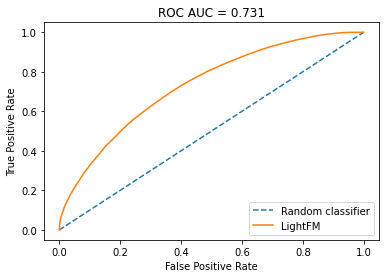

In [ ]:
#building ROC AUС
roc_auc_curve(test_data.rating,preds)

In [ ]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [ ]:
preds.min(), preds.max()

(-34.290783, 33.519196)

In [ ]:
normalized_preds.min(), normalized_preds.max()


(0.0, 1.0)

Let's male an experiment by training on the train without dividing it and predict the rating on test

In [ ]:
ratings_coo1 = sparse.coo_matrix((train['rating'].astype(int),
                                 (train['userid'],
                                  train['itemid'])))
model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)

model1 = model.fit(ratings_coo1, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

#getting predictions:
preds1 = model1.predict(test.userid.values,
                      test.itemid.values)

In [ ]:
normalized_preds1 = (preds1 - preds1.min())/(preds1 - preds1.min()).max()

In [ ]:
preds1.min(), preds1.max()

(-35.907223, 30.635885)

In [ ]:
normalized_preds1.min(), normalized_preds1.max()

(0.0, 1.0)

In [ ]:
test['pred_rating'] = normalized_preds1
test

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id,pred_rating
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0,0.570032
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1,0.560023
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2,0.546191
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3,0.546473
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4,0.566829
...,...,...,...,...,...,...,...,...,...,...,...,...
285960,True,"01 17, 2016",B00FLD3X28,A. Banks,1452988800,NaN,{'Size:': ' 1 Pound'},NaN,294,25601,285960,0.575025
285961,True,"08 22, 2015",B0078DQ85S,HighEnergy,1440201600,NaN,{'Flavor:': ' Cinnamon & Currant'},NaN,119653,18204,285961,0.475498
285962,True,"09 21, 2017",B000FZVLFS,Sam Jackson,1505952000,NaN,{'Flavor:': ' Espresso Forte'},NaN,54673,2287,285962,0.559583
285963,True,"03 27, 2018",B001PB801Y,Louis J. Dezseran Sr.,1522108800,NaN,{'Size:': ' 5lb'},NaN,16569,9343,285963,0.562165


Now let's train and predict on the cleaned data

In [ ]:
train_data, test_data = train_test_split(df,random_state=32, shuffle=True)
ratings_coo2 = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS, random_state = RANDOM_STATE)
model2 = model.fit(ratings_coo2, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [ ]:
#getting predictions:
preds2 = model2.predict(test_data.userid.values,
                      test_data.itemid.values)

In [ ]:
# roc_auc_score metric
sklearn.metrics.roc_auc_score(test_data.rating,preds2)

0.7421592222938557

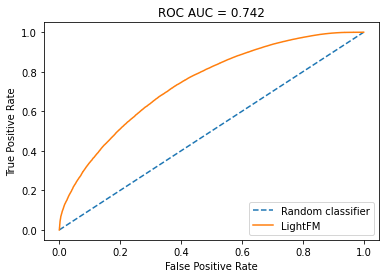

In [ ]:
#building ROC AUС
roc_auc_curve(test_data.rating,preds2)

we see that the metric has slightly improved 

In [ ]:
normalized_preds2 = (preds2 - preds2.min())/(preds2 - preds2.min()).max()
preds2.min(), preds2.max()

(-36.440193, 29.160967)

In [ ]:
normalized_preds2.min(), normalized_preds2.max()

(0.0, 1.0)

In [ ]:
preds_sub = model2.predict(test.userid.values,
                      test.itemid.values)

In [ ]:
normalized_preds_sub = (preds_sub - preds_sub.min())/(preds_sub - preds_sub.min()).max()
preds_sub.min(), preds_sub.max()

(-34.666294, 29.492027)

In [ ]:
normalized_preds_sub.min(), normalized_preds_sub.max()

(0.0, 1.0)

due to a memory error on kaggle, comment out the work with item and user features

In [ ]:
#indicate in item_features the features that describe the product and then make it sparse
# item_features matrix for further use in the model
item_features = train_data[['image','main_cat','brand_kind',
                            'price_high','price_low','price_middle','image']]
norm_ifeatures = (item_features - item_features.mean()) / item_features.std()
item_features=(sparse.csr_matrix(norm_ifeatures)).astype(np.float32)

In [ ]:
# make a sparse matrix user_features containing features describing the consumer
user_features = train_data[['verified','unixReviewTime','vote','also_buy_numb','also_view_numb']]
norm_ufeatures = (user_features - user_features.mean()) / user_features.std()
user_features = (sparse.csr_matrix(norm_ufeatures)).astype(np.float32)

In [ ]:
NUM_THREADS = 4  
NUM_COMPONENTS = 160  
NUM_EPOCHS = 20  
RANDOM_STATE = 32
model = LightFM(learning_rate=0.09, loss='logistic',
                no_components=NUM_COMPONENTS)
model_feat = model.fit(ratings_coo, user_features=user_features, 
                       item_features=item_features, epochs=NUM_EPOCHS,
                       num_threads=NUM_THREADS)

In [ ]:
#we use matrices for predictions
userid = np.array(test_data.userid).astype(np.int32)
itemid =np.array(test_data.itemid).astype(np.int32) 

In [ ]:
# getting predictions
preds0 = model_feat.predict(userid, itemid, item_features=item_features,
                            user_features=user_features,num_threads=NUM_THREADS)

In [ ]:
# metrics roc_auc_score
sklearn.metrics.roc_auc_score(test_data.rating,preds0)

0.5013854953437483

In [ ]:
# Getting embeddings

item_biases, item_embeddings = model2.get_item_representations()

In [ ]:
item_biases.shape, item_embeddings.shape

((41320,), (41320, 160))

We got embeddings. We need embeddings to give a prediction for each product, or rather, to look for the most similar ones. To quickly search among a large number of products, we will use the nearest neighbors method, approximate k-nn, which is implemented in the nmslib library.

Instead of iterating over all the vertices, we can traverse the graph very quickly.

In [ ]:
!pip install nmslib

     |████████████████████████████████| 13.5 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 188 kB 48.3 MB/s eta 0:00:01
  Attempting uninstall: pybind11
    Found existing installation: pybind11 2.7.1
    Uninstalling pybind11-2.7.1:
      Successfully uninstalled pybind11-2.7.1


In [ ]:
import nmslib
 
#Create our search graph
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Start adding our products to the graph
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [ ]:
#Auxiliary function for searching by graph
def nearest_item_nms(itemid, index, n=10):
    nn = index.knnQuery(item_embeddings[itemid], k=n)
    return nn

In [ ]:
mapper = dict(zip(meta['asin'],meta['title']))

In [ ]:
# creating dataframe prod_id
train['title'] = train.asin.apply(lambda x: mapper[x])
test['title'] = test.asin.apply(lambda x: mapper[x])
prod_id = train.drop(['verified','reviewTime','reviewerName','reviewText',
                      'summary','unixReviewTime','vote','style','image'],axis=1)

Let's try to write recommendations for some product. For example, to 'chocolate'.

In [ ]:
prod_id[prod_id.title.str.find('chocolate')>=0].head(5)

,overall,asin,userid,itemid,rating,title
7245,5.0,B00GXT7NJ8,6256,26561,1.0,Pernigotti Cocoa - 1 Kg (2.2 lbs) - from the f...
9687,4.0,B00OBO2GVM,28826,31074,1.0,Atkins endulge pieces - milk chocolate caramel...
11510,5.0,B0017OLEMQ,21565,6627,1.0,Sixlets 48 packs of candy coated chocolate candy
15346,5.0,B00069IHO6,20913,784,1.0,Milk Chocolate Rocks 3 pound bag (48 ounces of...
19385,5.0,B0017OLEMQ,35367,6627,1.0,Sixlets 48 packs of candy coated chocolate candy


let's take item_id == 31074

In [ ]:
# Looking for similar products
nbm = nearest_item_nms(31074,nms_idx)[0]

In [ ]:
# show them
prod_id[prod_id.itemid.isin(nbm)]

,overall,asin,userid,itemid,rating,title
3470,4.0,B00TU89MDE,108381,32741,1.0,Terrasoul Superfoods Organic Yacon Root Powder...
6388,5.0,B010AIER0K,127167,34435,1.0,Nature's Hollow Sugar-Free Honey Substitue (Ho...
9687,4.0,B00OBO2GVM,28826,31074,1.0,Atkins endulge pieces - milk chocolate caramel...
20841,4.0,B01AAQ6584,15248,36494,1.0,"Positively Tea Company, Organic Stevia Leaf, H..."
23350,4.0,B010AIER0K,76610,34435,1.0,Nature's Hollow Sugar-Free Honey Substitue (Ho...
...,...,...,...,...,...,...
799974,5.0,B00TU89MDE,34085,32741,1.0,Terrasoul Superfoods Organic Yacon Root Powder...
801920,2.0,B010AIER0K,124507,34435,0.0,Nature's Hollow Sugar-Free Honey Substitue (Ho...
806342,3.0,B00TU89MDE,21755,32741,0.0,Terrasoul Superfoods Organic Yacon Root Powder...
837310,5.0,B019LCCNZM,102521,36373,1.0,Fun Flavor Beef Jerky Variety Pack


In [ ]:
submission['rating']= normalized_preds_sub

In [ ]:
submission

,Id,rating
0,0,0.569760
1,1,0.556507
2,2,0.536288
3,3,0.540261
4,4,0.552494
...,...,...
285960,285960,0.578711
285961,285961,0.473687
285962,285962,0.557999
285963,285963,0.581513


In [ ]:
submission.to_csv('submission_log.csv', index=False)

Conclusion:

We have successfully completed a project to create a recommendation system. We have prepared a series of sequential models to evaluate the project using the ROC AUC metric. Which characterizes the accuracy of predictions and must be resistant to unbalanced classes.

We did a lot of work on EDA and Feature engineering, but we decided to start with a simple model, which, as expected, did not give us the desired effect, but set a starting point. The next step was to increase the data on which the model was trained, as the result we have improved until 0.7495 on submission, which is already noticeably better than the base solution. The next step was working with 'item_features' and embeddings. Embeddings are used to describe texts, images, videos and more in search engines and recommendation engines. We need embeddings to give a prediction for each product, or rather, to look for the most similar ones. With the help of 'user/item_features' we have added our features. If we use 'user/item_features' in training, then LifhtFM considers that each user and item has one characteristic unique to that user (or item). For a quick search among a large number of products, we used the nearest neighbors method, approximate k-nn, which is implemented in the nmslib library. Unfortunately, we did not use this model for the submission, because the metric we chose is close to 0.5.

Explication of the chosen metric.

As part of the goals and objectives of creating a recommendation system, we determined that the recommendation system (RS) should be aimed at increasing the profits of an online store. Thus, out of the five most established business metrics for evaluating RS, we settled on Sales and Revenue. We can also assume that our RS can influence such indicators as User Engagement and Behavior and Effects on Sales Distribution (not necessarily in a positive direction). This may depend both on the RS itself and on its interface, convenience, and the degree of customer confidence in it.

The ROC-AUC metric is most suitable for assessing the accuracy of predicting recommended products to increase sales. It can be added that if users are only interested in the highest (or lowest rated) products and not individual rating scores, this suggests a classification or ranking problem. While the algorithm may use predictive ratings internally, it must successfully score the highest rated (or lowest rated) items. Higher error in rating predictions for items is acceptable if the highest rated (or lowest rated) items are identified correctly. Therefore, evaluation should focus on classification or ranking indicators.

The ROC AUC graphic provides a graphical representation of the performance of a RS or any other type of binary classifier. It displays True Positive rate vs. False Positive rate to increase the size of the recommendation set. The obvious goal is to maximize the area under the curve. Thus, the area under the AUC curve can be used as a single measure of the overall quality of a recommender system. However, it often happens that users are more interested in products at the top of the recommendation lists, but the AUC is equally affected by the swaps at the top or bottom of the recommendation list. This can be a disadvantage if we are mainly interested in finding the top ranked items and therefore care about the first part of the graph. To solve this problem in the future, you can use LAUC (Limited Area Under the Curve). The LAUC measure can be very useful for evaluating RS that are used to create lists of superior products.